## Simple DNN to mimic StIC inversions 

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [80]:
# We are going to make a dense autoencoder here:


class testdnn(nn.Module):
    def __init__(self, inputsize, outputsize):
        super(testdnn, self).__init__()
        self.linear1 = nn.Linear(inputsize,16)
        self.linear1a = nn.Linear(16,16)
        self.linear2 = nn.Linear(16,16)
        self.linear2a = nn.Linear(16,8)
        self.linear3 = nn.Linear(8,8)
        self.linear4 = nn.Linear(8,16)
        self.linear5 = nn.Linear(16,16)
        self.linear6 = nn.Linear(16,outputsize)
        
        
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        
        self.dropout05 = nn.Dropout(0.5)
        
        
    def forward(self, data_in):
        
        x = self.linear1(data_in)
        x = self.activationS(x)
        x = self.linear1a(x)
        x = self.activationS(x)
        x = self.linear2(x)
        x = self.activationS(x)
        #x = self.linear2a(x)
        #x = self.activationS(x)
        #x = self.linear3(x)
        #x = self.activationS(x)
        #x = self.linear4(x)
        #x = self.activationS(x)
        x = self.linear5(x)
        x = self.activationS(x)
        data_out = self.linear6(x)
        #data_out = self.activationS(x)
            
        return data_out
    
def make_model(cudaoption, inputsize, outputsize):
    
    model = testdnn(inputsize, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi, w):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        w = w.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [81]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [82]:
dnn_model = make_model(cudaoption, 21, 13)

[INFO] Cuda model: NVIDIA RTX A2000 Laptop GPU
[INFO] Parameters in GPU: True


### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [83]:
from astropy.io import fits 
import numpy as np
import sparsetools as sp
import imtools as im #in the STiC example folder
import matplotlib.pyplot as plt 

In [84]:
data_out = fits.open("full_training_set_out.fits")
data_out.info()

Filename: full_training_set_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (5, 464, 280)   float64   
  1                1 ImageHDU         8   (5, 464, 280)   float64   
  2                1 ImageHDU         8   (3, 464, 280)   float64   


In [85]:
data_in = fits.open("full_training_set_in.fits")

In [86]:
stokes = data_in[0].data
stokes.shape

(280, 464, 21, 4)

In [87]:
data_in = stokes[:,:,:,0]
data_in = data_in.reshape(280*464, 21)

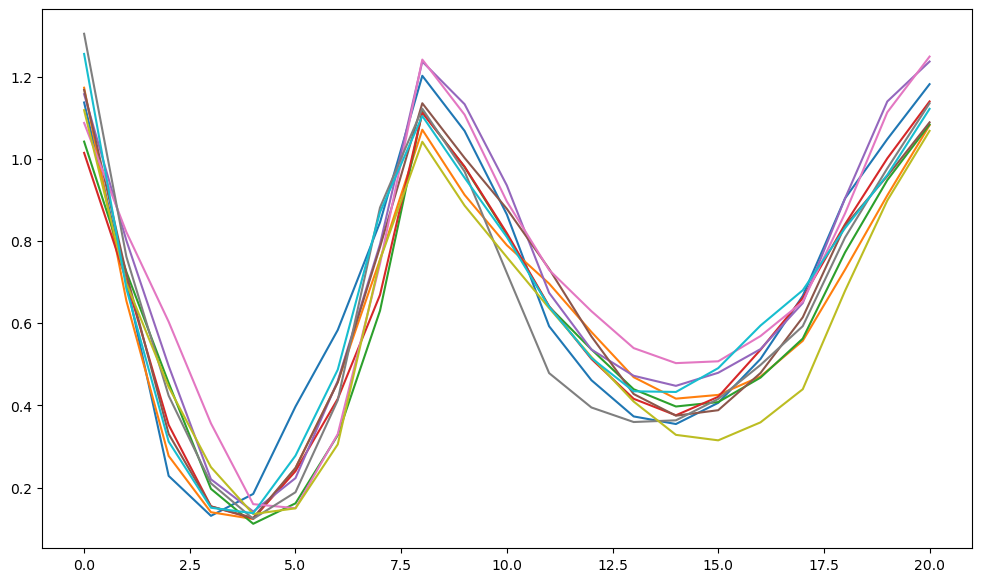

In [88]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_in[i*100])

In [89]:
# This looks nicely normalized but we can normalize it further:

In [90]:
data_in_norm = np.copy(data_in)

In [91]:
# Let's try with a normalization w.r.t. line core:
mean_spectrum = np.mean(data_in_norm,axis=(0))
w = np.sqrt(mean_spectrum)
w = torch.from_numpy(w.astype('float32'))

In [92]:
dimax = np.amax(data_in_norm)
dimin = np.amin(data_in_norm)

In [93]:
data_in_norm[:,:] = (data_in_norm[:,:] - dimin) / (dimax - dimin)

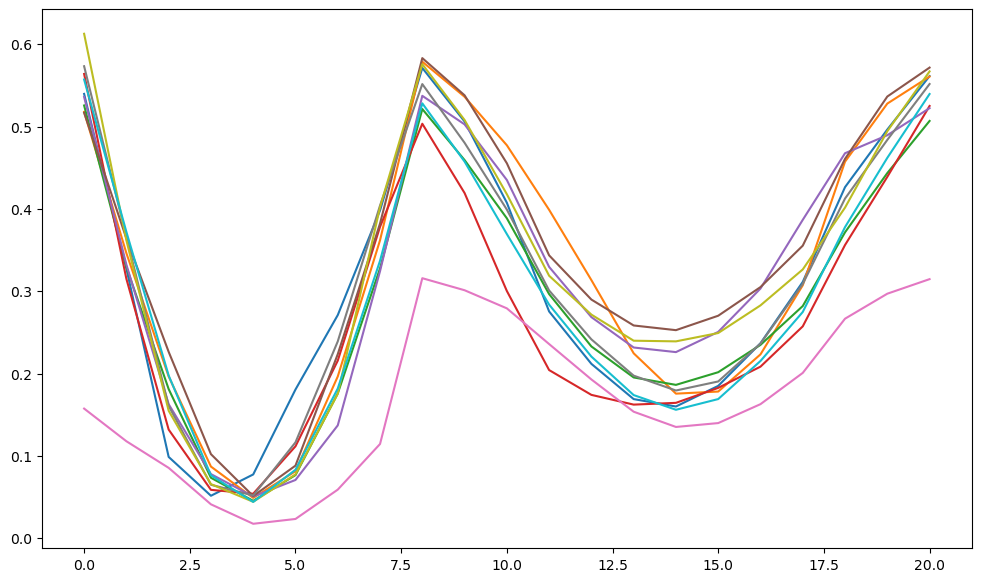

In [94]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_in_norm[i*10000])

In [95]:
data_in_norm = torch.from_numpy(data_in_norm.astype('float32'))

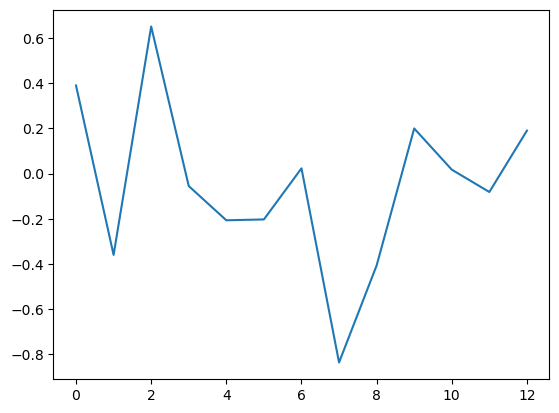

In [96]:
test_output = model_predict(dnn_model,data_in_norm[:10],cudaoption)
test_output.shape
plt.plot(test_output[0].detach().numpy())

### Normalize the output data:

In [97]:
data_out = fits.open("full_training_set_out.fits")

In [98]:
temp = data_out[0].data
vlos = data_out[1].data
vturb = data_out[2].data

# Normalizations:
max_t = np.amax(temp)
min_t = np.amin(temp)
max_vlos = np.amax(vlos)
min_vlos = np.amin(vlos)
max_vturb = np.amax(vturb)
min_vturb = np.amin(vturb)


In [99]:
print (temp.shape)
print (vlos.shape)
print (vturb.shape)

(280, 464, 5)
(280, 464, 5)
(280, 464, 3)


In [100]:
print(min_t,max_t)
print(min_vlos/1E5, max_vlos/1E5)
print(min_vturb/1E5, max_vturb/1E5)

3100.0 7952.3203125
-150.0 19.09949
0.0 12.70172375


In [106]:
bad = np.where(vlos < -20E5)
vlos[bad] = -20E5

In [107]:
NX = 280
NY = 464
NP = 13

In [108]:
min_vlos = -20.0E5

In [109]:
temp_norm = (temp-min_t) / (max_t - min_t)
vlos_norm = (vlos-min_vlos) / (max_vlos - min_vlos)
vturb_norm = (vturb-min_vturb) / (max_vturb - min_vturb)

In [110]:
data_out_norm = np.concatenate((temp_norm, vlos_norm, vturb_norm),axis=2)
data_out_norm = data_out_norm.reshape(NX*NY, NP)
data_out_norm.shape

(129920, 13)

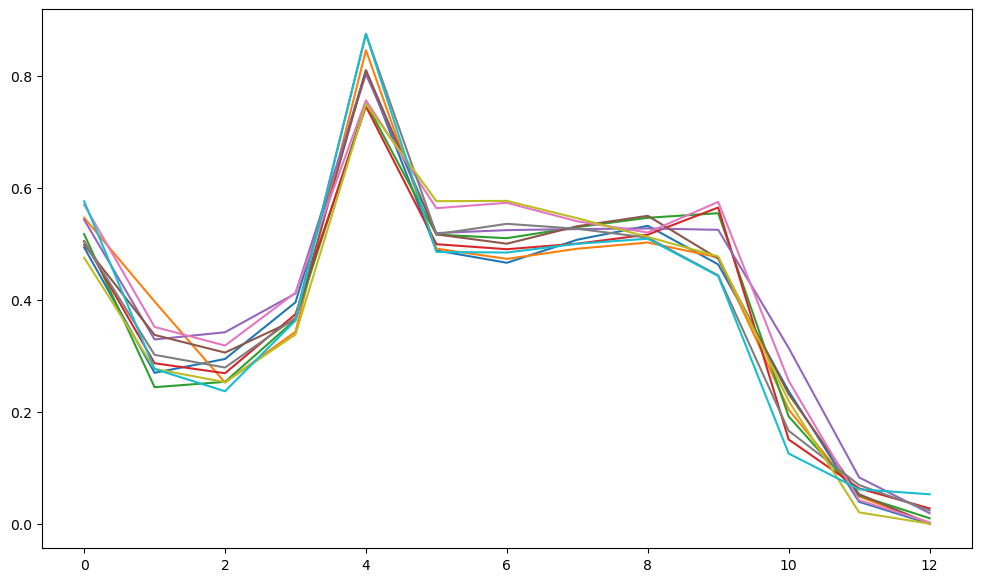

In [111]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_out_norm[i*100])

In [142]:
data_out_norm = torch.from_numpy(data_out_norm.astype('float32'))

In [143]:
convergence = compilefit(dnn_model, data_in_norm, data_out_norm, data_in_norm, data_out_norm, \
                         100000, 0, cudaoption, 1E-3, 1000, 128, 0, w)

 It : 1000 - residual std : 0.027387 - val std : 0.027387
 It : 2000 - residual std : 0.027376 - val std : 0.027376
 It : 3000 - residual std : 0.027365 - val std : 0.027365
 It : 4000 - residual std : 0.027355 - val std : 0.027355
 It : 5000 - residual std : 0.027347 - val std : 0.027346
 It : 6000 - residual std : 0.027332 - val std : 0.027332
 It : 7000 - residual std : 0.027339 - val std : 0.027349
 It : 8000 - residual std : 0.027381 - val std : 0.027393
 It : 9000 - residual std : 0.027298 - val std : 0.027298
 It : 10000 - residual std : 0.027821 - val std : 0.027749
 It : 11000 - residual std : 0.027291 - val std : 0.027303
 It : 12000 - residual std : 0.027284 - val std : 0.027313
 It : 13000 - residual std : 0.027253 - val std : 0.027253
 It : 14000 - residual std : 0.027474 - val std : 0.027316
 It : 15000 - residual std : 0.027231 - val std : 0.027231
 It : 16000 - residual std : 0.027221 - val std : 0.027221
 It : 17000 - residual std : 0.027210 - val std : 0.027210
 It : 

In [144]:
torch.save(dnn_model, 'sstinv_full_take_1.pt')

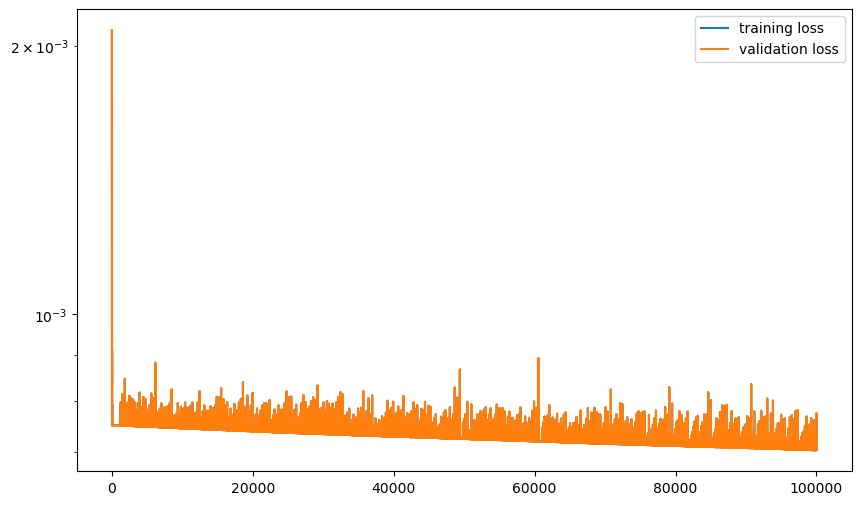

In [145]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

### Here we do some statistical analysis of the "compression"

In [146]:
test_output = model_predict(dnn_model,data_in_norm,cudaoption)

In [147]:
data_reconstructed = test_output.detach().numpy()

In [148]:
data_out_norm = data_out_norm.detach().numpy()

(280, 464)


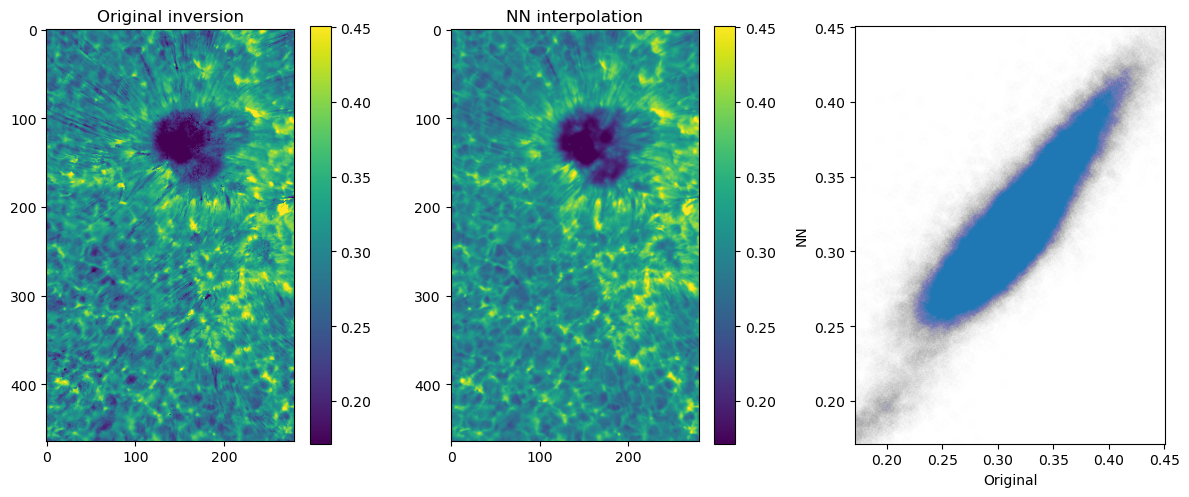

In [153]:
NX = 280
NY = 464
NP = 13
# Test some plots here:
i = 2
plt.figure(figsize=[12,5])

plt.subplot(131)
temp = data_out_norm.reshape(NX,NY,NP)[:,:,i]
print(temp.shape)
v_min = np.mean(temp) - 3 * np.std(temp)
v_max = np.mean(temp) + 3 * np.std(temp)
plt.imshow(data_out_norm.reshape(280, 464, NP)[:,:,i].T,vmin=v_min,vmax=v_max)
plt.title("Original inversion")
plt.colorbar()

plt.subplot(132)
plt.imshow(data_reconstructed.reshape(280,464,NP)[:,:,i].T, vmin=v_min,vmax=v_max)
plt.title("NN interpolation")
plt.colorbar()

plt.subplot(133)
plt.scatter(data_out_norm.reshape(280,464,NP)[:,:,i], data_reconstructed.reshape(280,464,NP)[:,:,i],alpha=0.002)
plt.xlim([v_min,v_max])
plt.ylim([v_min,v_max])
plt.xlabel("Original")
plt.ylabel("NN")
plt.tight_layout()

In [154]:
print(np.std(data_out_norm.reshape(NX, NY, NP)[:,:,i] - data_reconstructed.reshape(NX, NY, NP)[:,:,i])*(max_t-min_t))

94.38373771343322
